## PHR Stereo archive search

### Libraries

In [1]:
import requests
from pathlib import Path
import json
import geopandas as gp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from datetime import timedelta

### Credentials

In [2]:
# PROJECT CREDENTIALS

# Path, load read json with credential secrets
proj_conf_file_path = Path.cwd()/'project-config-file.json'

# Opening JSON file and load into dict
open_proj_conf_file = open(proj_conf_file_path)
project_credentials = json.load(open_proj_conf_file)

In [3]:
# PROJECT CREDENTIALS

client_id = project_credentials['project_id']
client_secret = project_credentials['project_api_key']

### Functions

In [40]:
# Get access token
def get_ptoken(client_id, client_secret):
    response = requests.post("https://api.up42.com/oauth/token",
                             data={"grant_type": "client_credentials"},
                             auth=(client_id, client_secret)
                            )
    
    return response.json()["access_token"]

# Get all hosts
def get_list_hosts(PTOKEN):
    response = requests.get("https://api.up42.com/hosts",
                            data={"grant_type": "client_credentials"},
                            headers={"Authorization": "Bearer " + PTOKEN}
                           )
    return response.json()["data"]

# Search data through Hosts 
def search_hosts(PTOKEN, HOST_NAME):
    response = requests.post("https://api.up42.com/catalog/hosts/"+HOST_NAME+"/stac/search",
                            headers={"Authorization": "Bearer " + PTOKEN,
                                    "Content-Type" : "application/json"},
                             data=updated_payload
                           )
    return response.json()

### Available Hosts

In [41]:
# Build our host list calling "build_host_list()" function

PTOKEN = get_ptoken(client_id, client_secret)
#PTOKEN

hosts_name = get_list_hosts(PTOKEN)
current_host_list = [((hosts_name)[i]['name']) for i in range(len(hosts_name))]

current_host_list

['capellaspace', 'nearspacelabs', '21at', 'Sobloo', 'oneatlas', 'airbus']

### AOI

In [51]:
# Manage aoi file for use in payload or results plot

# AOI file path
aoi_file_path = Path.cwd()/'aoi/aoi_imrali_adasi.geojson'

# Opening JSON file and load into variable aoi
aoi_file = open(aoi_file_path)
aoi = json.load(aoi_file)

# Use geopandas to read aoi file and extract aoi bounds
gpaoi = gp.read_file(aoi_file_path)
bounds = gpaoi.total_bounds

# Bbox coordinates for payload if wanted
bbox_coord = [bounds[0], bounds[1], bounds[2], bounds[3]]

# Intersects coordinate for payload if wanted
intersects_coord = aoi['features'][0]['geometry']

aoi

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[28.482056, 40.493959],
      [28.482056, 40.586321],
      [28.589859, 40.586321],
      [28.589859, 40.493959],
      [28.482056, 40.493959]]]}}]}

### Search parameters / Payload

In [23]:
# Search parameters from file - here we essentially set a template payload that is built properly (we can update parameters in the next code block)

# File path
file_path = Path.cwd()/'search_params/sr_og.json'

# Opening JSON file and load into dict
sr_file = open(file_path)
payload = json.load(sr_file)
payload

{'datetime': '2019-03-22T00:00:00Z/2019-03-24T23:59:59Z',
 'intersects': {'type': 'Polygon',
  'coordinates': [[[13.58899063, 52.72706317],
    [13.8941314, 52.73057866],
    [13.89381997, 52.4393652],
    [13.58935102, 2.43718654],
    [1.58899063, 52.72706317]]]},
 'limit': 500,
 'collections': ['PHR'],
 'query': {'cloudCoverage': {'lte': 90},
  'resolution': {'lte': 0.3},
  'up42:usageType': {'in': ['DATA', 'ANALYTICS']},
  'deliveryTime': {'in': ['HOURS', 'MINUTES']},
  'producer': {'in': ['Airbus']},
  'processingLevel': {'in': ['ALBUM', 'SENSOR']}}}

In [24]:
# Search parameters - update payload query options ("Airbus","TWENTY_ONE_AT", "ESA", "CAPELLA_SPACE", "NEAR_SPACE_LABS")
# Collection options: "phr", "spot", "pneo"

payload["datetime"] = "2021-01-01T00:00:00Z/2021-01-31T23:59:59Z"

#del payload["intersects"]
payload["intersects"] = intersects_coord

#del payload["bbox"]
#payload["bbox"] = bbox_coord

#del payload["contains"]
#payload["contains"] = intersects_coord

#del payload["limit"]
payload["limit"] = 500

#del payload["collections"]
payload["collections"] = ["phr", "spot"]

#del payload["query"]["cloudCoverage"]["lte"]
payload["query"]["cloudCoverage"]["lte"] = 50

#del payload["query"]["resolution"]["lte"]
payload["query"]["resolution"]["lte"] = 1

del payload["query"]["producer"]
#payload["query"]["producer"]["in"] = []

del payload["query"]["up42:usageType"]
#payload["query"]["up42:usageType"]["in"] = []

del payload["query"]["processingLevel"]
#payload["query"]["processingLevel"]["in"] = []

del payload["query"]["deliveryTime"]
#payload["query"]["deliveryTime"]["in"] = []

updated_payload = json.dumps(payload)
updated_payload

'{"datetime": "2021-01-01T00:00:00Z/2021-01-31T23:59:59Z", "intersects": {"type": "Polygon", "coordinates": [[[28.482056, 40.493959], [28.482056, 40.586321], [28.589859, 40.586321], [28.589859, 40.493959], [28.482056, 40.493959]]]}, "limit": 500, "collections": ["phr", "spot"], "query": {"cloudCoverage": {"lte": 50}, "resolution": {"lte": 1}}}'

### Single host search

In [96]:
# Remember tokens run out after FIVE MINUTES, refresh often
PTOKEN = get_ptoken(client_id, client_secret)

In [100]:
# Search for data and pass results to geodataframe - change the host name to search other hosts ['capellaspace', 'nearspacelabs', '21at', 'Sobloo', 'oneatlas']
HOST_NAME = "oneatlas"
search_results = search_hosts(PTOKEN, HOST_NAME)

try:
    gp_search_result = gp.GeoDataFrame.from_features(search_results)
    
    # Number of scenes found
    print(f"{len(gp_search_result['collection'])} {HOST_NAME} scenes found")

    # Break down per collection (mostly for oneatlas)
    print(gp_search_result['collection'].value_counts())

except:
    print(f'No data found or there was an error')
    print(search_results)


5 oneatlas scenes found
spot    5
Name: collection, dtype: int64


In [101]:
# Available keys that can be used to fine tune search based on available metadata
gp_search_result.keys()

Index(['geometry', 'id', 'constellation', 'collection', 'providerName',
       'up42:usageType', 'providerProperties', 'sceneId', 'producer',
       'acquisitionDate', 'start_datetime', 'end_datetime', 'cloudCoverage',
       'resolution', 'deliveryTime'],
      dtype='object')

In [102]:
# This will print some metadata about the returned scenes
for i in range(len(gp_search_result)):   
        print(f"{i}, {gp_search_result.acquisitionDate[i]} - - > {gp_search_result.providerProperties[i]['parentIdentifier']}")

0, 2021-01-31T08:39:59.499Z - - > DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790
1, 2021-01-31T08:39:24.624Z - - > DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790
2, 2021-01-06T08:32:03.499Z - - > DS_SPOT6_202101060832035_TR1_TR1_TR1_TR1_E029N41_04307
3, 2021-01-05T08:40:19.624Z - - > DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790
4, 2021-01-05T08:39:44.749Z - - > DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790


### Stereo data

Methodology:
Currently there are no tags or id values common to stereo pairs. In order to identify possible pairs we must filter scenes by time of acquisition and then compare Variable Key Information found in the parentIdentifier key. 

Steps:
First - we will build a dictionary containing 'parentIdentifier' and 'acquisitionDate' for each scene.
Second - we will compare each scene 'acquisitionDate' to each other and build a list of scene 'parentIdentifier' that pass a time range filter. This list will be the value to a new key named 'validated_times'.
Third - we will perform a Variable Key Information validation process. We will in essence compare each scene 'parentIdentifier' to the ones in the 'validated_times' key. We will build a new key called 'stereo_pair' with values the 'parentIdentifier' of the scenes that pass the validation process.

In [103]:
# Build dictionary with all search results containing key values: parent_id, acquisition_time

bundle_dict = {}
for i in range(len(gp_search_result)):
    
    parentIdentifier = gp_search_result.providerProperties[i]['parentIdentifier']
    acqui_time = gp_search_result.acquisitionDate[i]
    bundle_dict[i] = {"parent_id":parentIdentifier, "acqui_time":acqui_time}

bundle_dict

{0: {'parent_id': 'DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790',
  'acqui_time': '2021-01-31T08:39:59.499Z'},
 1: {'parent_id': 'DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-31T08:39:24.624Z'},
 2: {'parent_id': 'DS_SPOT6_202101060832035_TR1_TR1_TR1_TR1_E029N41_04307',
  'acqui_time': '2021-01-06T08:32:03.499Z'},
 3: {'parent_id': 'DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-05T08:40:19.624Z'},
 4: {'parent_id': 'DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-05T08:39:44.749Z'}}

#### Validate time

In [105]:
# For each row(key) in our dictionary we will use the acquisition time and run an inner for loop to compare this reference acquisition time against all the
# other scenes in the dictionary. If a scene passes our time requirements it is added to the valid_delta_time_list. Update bundle_dict dictionary with a new key "validated_times".

# Outer loop - to set a reference  
for row in bundle_dict:
    valid_delta_time_list = []
    reference_input_scene = bundle_dict[row]['parent_id']
    
    # Handle time format exception, for data from 2020 and earlier, time acquisition stamps is different
    try:
        reference_time = datetime.strptime(bundle_dict[row]['acqui_time'], "%Y-%m-%dT%H:%M:%S.%fZ")
    
    except:
        reference_time = datetime.strptime(bundle_dict[row]['acqui_time'], "%Y-%m-%dT%H:%M:%SZ")
    
    print(f"\n# # # - - NEXT  REFERENCE SCENE - -> {reference_input_scene}, {reference_time}")
    
    # Inner loop -  here we compare our reference to all other rows in the dictionnary
    for scene in bundle_dict:

        print(f"{reference_input_scene} < - > {bundle_dict[scene]['parent_id']}")
        
        if reference_input_scene != bundle_dict[scene]['parent_id']:
            print('## These scenes are different ##')
            
            # Handle time format exception
            try:
                scene_time = datetime.strptime(bundle_dict[scene]['acqui_time'], "%Y-%m-%dT%H:%M:%S.%fZ")
            except:
                scene_time = datetime.strptime(bundle_dict[scene]['acqui_time'], "%Y-%m-%dT%H:%M:%SZ")
            
            print(reference_time, scene_time)
            
            # Handle the subtraction order (this changes if the ref_scene is more or less recent that the other scene_time)
            if reference_time > scene_time:
                t_delta = (reference_time - scene_time)
                print(t_delta)
            else:
                t_delta = (scene_time - reference_time)
                print(t_delta)
            
            # We keep scenes that are within 100 seconds of our reference scene.
            if 100 > t_delta.seconds > 0 and  t_delta.days <= 1:
                print(f" - -> VALID {bundle_dict[scene]['acqui_time']}")
                
                # Create the new dict key
                valid_delta_time_list.append(bundle_dict[scene]['parent_id'])
                print(f'{valid_delta_time_list} \n')
            
                # Update the key with our list
                validated_times_key_value = {"validated_times": valid_delta_time_list}
                bundle_dict[row].update(validated_times_key_value)
            
            else:
                print(f" Scene out of time range\n")
                
        else:
            print(f"Skip this is the same as input reference scene\n")
            


# # # - - NEXT  REFERENCE SCENE - -> DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790, 2021-01-31 08:39:59.499000
DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790 < - > DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790
Skip this is the same as input reference scene

DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790 < - > DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790
## These scenes are different ##
2021-01-31 08:39:59.499000 2021-01-31 08:39:24.624000
0:00:34.875000
 - -> VALID 2021-01-31T08:39:24.624Z
['DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790'] 

DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790 < - > DS_SPOT6_202101060832035_TR1_TR1_TR1_TR1_E029N41_04307
## These scenes are different ##
2021-01-31 08:39:59.499000 2021-01-06 08:32:03.499000
25 days, 0:07:56
 Scene out of time range

DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790 < - > DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790
## These scenes are different ##
2021

In [109]:
# Print bundle_dict to see the updates
bundle_dict

{0: {'parent_id': 'DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790',
  'acqui_time': '2021-01-31T08:39:59.499Z',
  'validated_times': ['DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790']},
 1: {'parent_id': 'DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-31T08:39:24.624Z',
  'validated_times': ['DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790']},
 2: {'parent_id': 'DS_SPOT6_202101060832035_TR1_TR1_TR1_TR1_E029N41_04307',
  'acqui_time': '2021-01-06T08:32:03.499Z'},
 3: {'parent_id': 'DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-05T08:40:19.624Z',
  'validated_times': ['DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790']},
 4: {'parent_id': 'DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-05T08:39:44.749Z',
  'validated_times': ['DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790']}}

#### Variable Key Information validation process

In [111]:
# We will perform a validation process on each scene against the parentIdentifiers that can now be found in 'validated_times' key. 

# Outer loop - to set a reference 
for key in bundle_dict:
    
    # Check if dictionary ['validated_times'] key exist
    try:
        bundle_dict[key]['validated_times']

        # Reference scene variable key information
        ref_SAT_NUMBER = bundle_dict[key]['parent_id'][0:8]
        ref_XxxxYyy = bundle_dict[key]['parent_id'][32:39]
        ref_KKLL = bundle_dict[key]['parent_id'][-10:-6]
        ref_TTTTT = bundle_dict[key]['parent_id'][-5:]

        print(f"Ref scene ID: {bundle_dict[key]['parent_id']}")

        # List to perform the validation process on
        print(f"Time validated list: {bundle_dict[key]['validated_times']}")

        # Inner loop, for the key/row/entry we are currently in, we loop over the values in 'validated_times' against our reference parent_id
        stereo_pair_list = []        
        for item in bundle_dict[key]['validated_times']:
#            print(item[0:8], item[32:39], item[-10:-6], item[-5:])
            print("Start validation")

            if ref_SAT_NUMBER == item[0:8]:
                print(f'{ref_SAT_NUMBER} - - - > {item[0:8]}')
                if ref_XxxxYyy == item[32:39]:
                    print(f'{ref_XxxxYyy} - - - > {item[32:39]}')
                    if ref_KKLL == item[-10:-6]:
                        print(f'{ref_KKLL} - - - > {item[-10:-6]}')
                        print(f'PASSED Variable Key Information validation process')

                        stereo_pair_list.append(item)  
                        print(f'{stereo_pair_list} \n')                              
                    else:
                        print(f'Failed Variable Key Information validation process on KKLL')
                else:
                        print(f'Failed Variable Key Information validation process on XxxxYyy')
            else:
                        print(f'Failed Variable Key Information validation process on SAT_NUMBER')
        print(stereo_pair_list)

        stereo_pair_key_value = {"stereo_pair":stereo_pair_list}
        bundle_dict[key].update(stereo_pair_key_value)

    except:
#        bundle_dict[key].pop('stereo_pair')
        continue

Ref scene ID: DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790
Time validated list: ['DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790']
Start validation
DS_SPOT7 - - - > DS_SPOT7
Failed Variable Key Information validation process on XxxxYyy
[]
Ref scene ID: DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790
Time validated list: ['DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790']
Start validation
DS_SPOT7 - - - > DS_SPOT7
Failed Variable Key Information validation process on XxxxYyy
[]
Ref scene ID: DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790
Time validated list: ['DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790']
Start validation
DS_SPOT7 - - - > DS_SPOT7
_FR1_FR - - - > _FR1_FR
8N41 - - - > 8N41
PASSED Variable Key Information validation process
['DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790'] 

['DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790']
Ref scene ID: DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790
Time validat

In [114]:
# print to see updates
bundle_dict

{0: {'parent_id': 'DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790',
  'acqui_time': '2021-01-31T08:39:59.499Z',
  'validated_times': ['DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790'],
  'stereo_pair': []},
 1: {'parent_id': 'DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-31T08:39:24.624Z',
  'validated_times': ['DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790'],
  'stereo_pair': []},
 2: {'parent_id': 'DS_SPOT6_202101060832035_TR1_TR1_TR1_TR1_E029N41_04307',
  'acqui_time': '2021-01-06T08:32:03.499Z'},
 3: {'parent_id': 'DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-05T08:40:19.624Z',
  'validated_times': ['DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790'],
  'stereo_pair': ['DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790']},
 4: {'parent_id': 'DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790',
  'acqui_time': '2021-01-05T08:39:44.749Z',
  'validated_times': ['DS_SPOT7_20

In [116]:
# Print the results for better readiblity (there are duplicates)
for resi in bundle_dict:
    try:
        bundle_dict[key]['validated_times']
        
        parid = bundle_dict[resi]["parent_id"]
        stereopair = bundle_dict[resi]["stereo_pair"]
    
        print(f"Parent: {parid} has pair {stereopair}")
    except:
        continue

Parent: DS_SPOT7_202101310839595_FR1_FR1_SV1_SV1_E028N41_01790 has pair []
Parent: DS_SPOT7_202101310839246_FR1_FR1_FR1_FR1_E028N41_01790 has pair []
Parent: DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790 has pair ['DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790']
Parent: DS_SPOT7_202101050839447_FR1_FR1_FR1_FR1_E028N41_01790 has pair ['DS_SPOT7_202101050840196_FR1_FR1_FR1_FR1_E028N41_01790']


### Plot results

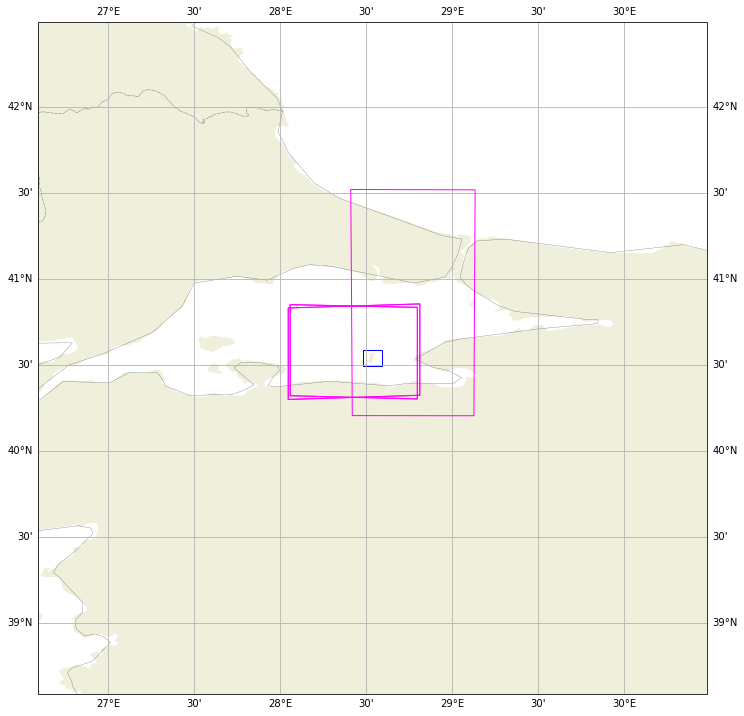

In [117]:
# Plot coverage
zoom_factor = 2
fig = plt.figure(figsize=(12, 16))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='darkslategray', linewidth=0.25)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.LAND, zorder=0)
ax.set_extent([bounds[0]+zoom_factor, bounds[2]-zoom_factor, bounds[1]+zoom_factor, bounds[3]-zoom_factor])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.add_geometries(gpaoi.geometry, crs=ccrs.PlateCarree(),
                  edgecolor='blue', facecolor='none', zorder = 2)
#ax.add_geometries(all_host_results.geometry, crs=ccrs.PlateCarree(),
#                  edgecolor='magenta', facecolor='none', zorder = 3)
ax.add_geometries(gp_search_result.geometry, crs=ccrs.PlateCarree(),
                  edgecolor='magenta', facecolor='none', zorder = 4)


plt.show()

If you have any questions or would like advice on other up42 things, feel free to reach out!!
Happy developing - Alex (alex.bishop@up42.com)